## Brief Problem Description
Given an input file which has the location of a person based on cellular tower triangulation, generate an output with 2 columns,
containing one row for each input line, tagging it as a tower jump (erroneous localization) and a confidence level (expressed as a number between 0 and 1)

## References

https://www.tinybird.co/blog-posts/anomaly-detection

https://medium.com/analytics-vidhya/removing-outliers-understanding-how-and-what-behind-the-magic-18a78ab480ff


## Solution (TLDR)

1. if lat and lon are zero -> flag as jump ( I hope John Doe is not visiting [Null Island](https://en.wikipedia.org/wiki/Null_Island) )
2. order the full dataset by datetime
3. calculate diff in minutes between points
4. calculate quartile of 80% in min (this was selected by me at random, it will be a variable in case we want to play with it)
5. group measurements in cluster when the time in minutes between rows is below the 80% quartile
6. remove outliers, calculate z value for lat and lon, any row that has either lon or lat below z +- 2 std, will be flagged as jump
7. calculate confidence as how close the lat and lon are to z if it is not a jump, or 1 - diff if it was flagged as jump
8. reorder output based on page and item number

## This Notebook
... was used when attempting to extract relevant data from the sample to write the solution, so it is not necessarily in an order
to help understand the solution, but in the order the data was being analysed.

## Initial Assumptions
Given the nature of the problem, which does not appear to have an exact solution that can be solved by a formal algorithm (the request to use a "confidence level" in the output gave that hint), we will try some statistical approach.
1- This appears to be a particular case of anomaly detection, and it will be handled as such
2- Many simplifications will be done given the limitations of time
3- A Script will be provided that can be called on the command line to produce the output, given the input is in the same format that the one provided in the challenge description

### Loading input
First load the input file and check the content:

In [110]:
import pandas as pd

INPUT_PATH = "TowerJumpsDataSet_CarrierRecords.csv"

df = pd.read_csv(INPUT_PATH)
df.head(5)

,Page Number,Item Number,Local Date & Time,Latitude,Longitude,Time Zone,County,State,Country,Record Type
0,1,1,1/2/21 16:18,40.88837,-72.444778,America/New_York,Suffolk,New York,United States,Voice
1,1,2,1/2/21 20:31,40.88837,-72.444778,America/New_York,Suffolk,New York,United States,Voice
2,1,3,1/2/21 20:31,40.88837,-72.444778,America/New_York,Suffolk,New York,United States,Voice
3,1,4,1/2/21 20:31,40.88837,-72.444778,America/New_York,Suffolk,New York,United States,Voice
4,1,5,1/2/21 21:23,40.88837,-72.444778,America/New_York,Suffolk,New York,United States,Voice


Now, we look at all values in the columns to try to get a perspective of how this data is distributed.
By running `describe`, nothing particular draws our attention, except that the page number and item number do not seem relevant to our analysis.

In [111]:
df.describe()

,Page Number,Item Number,Latitude,Longitude
count,129095.000000,129095.000000,129095.000000,129095.000000
mean,4683.623789,40411.737317,39.016694,-70.329785
std,2821.680413,31191.961922,8.601096,15.915163
min,1.000000,1.000000,0.000000,-107.092730
25%,2248.000000,10630.000000,40.855000,-73.659580
50%,4580.000000,35634.000000,40.931083,-73.648300
75%,7052.500000,67877.500000,41.005100,-72.444778
max,9494.000000,99999.000000,41.238499,73.648300


In [112]:
len(df.index)

129095

Time zone appears to have 2 exotic values: Etc and Asia. Let´s look a bit closer at what data they have.

In [113]:
df["Time Zone"].value_counts()

Time Zone
America/New_York    121761
Etc/GMT               5951
America/Denver        1378
Asia/Bishkek             5
Name: count, dtype: int64

Asia has only 5 entries, the location (lat and lon) might be correct, though.

In [114]:
df[df["Time Zone"]=="Asia/Bishkek"].head(10)

,Page Number,Item Number,Local Date & Time,Latitude,Longitude,Time Zone,County,State,Country,Record Type
505,31,506,2/5/21 16:16,41.005100,73.648300,Asia/Bishkek,unknown,unknown,United States,Voice
506,31,507,2/5/21 16:16,41.005100,73.648300,Asia/Bishkek,unknown,unknown,NaN,Voice
550,34,551,2/7/21 17:51,41.005100,73.648300,Asia/Bishkek,unknown,unknown,NaN,Voice
551,34,552,2/7/21 17:51,41.005100,73.648300,Asia/Bishkek,unknown,unknown,NaN,Voice
4868,308,4847,4/25/22 19:44,41.052907,73.562948,Asia/Bishkek,unknown,unknown,United States,Voice


ETC has no good value for lat and lon, so this one can possibly be a case for automatically flagging it as a jump with high confidence.

In [115]:
df[df["Time Zone"]=="Etc/GMT"].head(10)

,Page Number,Item Number,Local Date & Time,Latitude,Longitude,Time Zone,County,State,Country,Record Type
13,1,14,1/3/21 21:05,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
29,2,30,1/5/21 21:37,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
32,2,33,1/5/21 21:38,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
57,4,58,1/7/21 1:04,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
65,5,66,1/7/21 17:11,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
66,5,67,1/7/21 17:11,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
71,5,72,1/7/21 19:22,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
72,5,73,1/7/21 19:26,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
96,7,97,1/8/21 22:10,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
101,7,102,1/8/21 22:30,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice


In [116]:
df[df["Time Zone"]=="Etc/GMT"][["Latitude","Longitude"]].describe()

,Latitude,Longitude
count,5951.0,5951.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


Country is either USA or NaN, so nothing extraordinary here.

In [117]:
df["Country"].value_counts()

Country
United States    80059
Name: count, dtype: int64

States look OK, except for the `unknown` value. However, some of the `unknown` have non zero lat/lon location, so this alone is possibly not a good indicator of a jump.

In [118]:
df["State"].value_counts()

State
New York       76968
Connecticut    40240
unknown        10508
Colorado        1377
New Jersey         2
Name: count, dtype: int64

In [119]:
df[df["State"]=="unknown"].head(10)

,Page Number,Item Number,Local Date & Time,Latitude,Longitude,Time Zone,County,State,Country,Record Type
13,1,14,1/3/21 21:05,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
29,2,30,1/5/21 21:37,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
32,2,33,1/5/21 21:38,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
57,4,58,1/7/21 1:04,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
65,5,66,1/7/21 17:11,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
66,5,67,1/7/21 17:11,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
71,5,72,1/7/21 19:22,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
72,5,73,1/7/21 19:26,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
96,7,97,1/8/21 22:10,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice
101,7,102,1/8/21 22:30,0.0,0.0,Etc/GMT,unknown,unknown,United States,Voice


In [120]:
df[df["State"]=="unknown"][["Latitude","Longitude"]].describe()

,Latitude,Longitude
count,10508.000000,10508.000000
mean,17.688965,-32.000576
std,20.215249,36.713489
min,0.000000,-106.839243
25%,0.000000,-73.956350
50%,0.000000,0.000000
75%,40.783850,0.000000
max,41.197800,73.648300


Record Type does not seem to give valuable information for our task.

In [121]:
df["Record Type"].value_counts()

Record Type
Data     113657
SMS        7733
Voice      7518
Name: count, dtype: int64

Datetime can be used to gather interesting information, like the distribution of the records over time.

In [122]:
df["Datetime"] = pd.to_datetime(df["Local Date & Time"], format="%m/%d/%y %H:%M")

In [123]:
df = df.sort_values(by=["Datetime"])

In [124]:
df["Datetime"].describe()

count                           129095
mean     2021-12-04 02:47:22.896161792
min                2021-01-01 13:40:00
25%                2021-06-03 13:57:30
50%                2021-11-17 22:52:00
75%                2022-05-23 12:54:00
max                2023-01-01 04:34:00
Name: Datetime, dtype: object

In [125]:
cleansed_df = df[df["Datetime"].notnull()]

In [126]:
null_datetime_df = df[df["Datetime"].isnull()]

In [127]:
null_datetime_df.head()

,Page Number,Item Number,Local Date & Time,Latitude,Longitude,Time Zone,County,State,Country,Record Type,Datetime


In [128]:
len(df.index)

129095

In [129]:
df["DatetimeDelta"] =  df["Datetime"] - df["Datetime"].shift(1)
df["DatetimeDelta"] = df["DatetimeDelta"].fillna(0)

## DatetimeDeltaMinutes
This is an interesting metric because it shows the distribution of data.
In practise, this means that the effect that many records with the same location happen in a short period of time, in bursts,
is very common in this dataset.
I do not have any expertise in cellular tower location algorithms, but statiscally, we will consider that if a position is reported
repeatedly, this will mean it is more relevant and has a higher chance of being correct.

In [130]:
df["DatetimeDeltaMinutes"] = df["DatetimeDelta"].apply(lambda x: (x.total_seconds())/60 if x else 0)

In [131]:
df[["Datetime","DatetimeDelta","DatetimeDeltaMinutes"]].head(10)

,Datetime,DatetimeDelta,DatetimeDeltaMinutes
7527,2021-01-01 13:40:00,0,0.0
7528,2021-01-01 13:40:00,0 days 00:00:00,0.0
7530,2021-01-01 14:40:00,0 days 01:00:00,60.0
7529,2021-01-01 14:40:00,0 days 00:00:00,0.0
121343,2021-01-01 15:04:00,0 days 00:24:00,24.0
7532,2021-01-01 15:40:00,0 days 00:36:00,36.0
7531,2021-01-01 15:40:00,0 days 00:00:00,0.0
7533,2021-01-01 15:54:00,0 days 00:14:00,14.0
7534,2021-01-01 15:55:00,0 days 00:01:00,1.0
7535,2021-01-01 15:56:00,0 days 00:01:00,1.0


In [132]:
df["DatetimeDeltaMinutes"].describe()

count    129095.000000
mean          8.138611
std          41.371886
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         825.000000
Name: DatetimeDeltaMinutes, dtype: float64

Now we can visualize that the vast majority of interval between measurements is actually pretty small, and also that
the 90% quartile is 16 minutes.

<Axes: xlabel='DatetimeDeltaMinutes', ylabel='Count'>

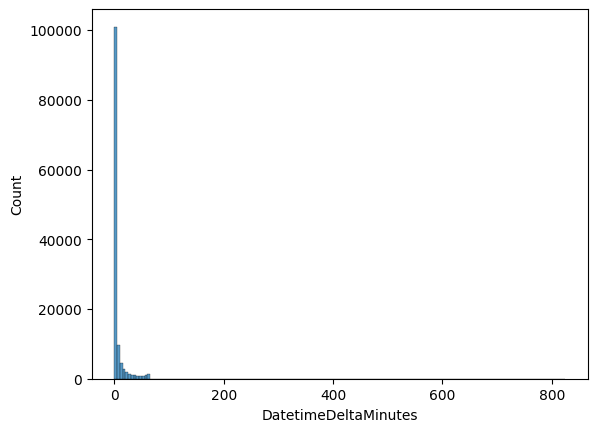

In [133]:
import seaborn as sns
sns.histplot(data=df[["Datetime","DatetimeDeltaMinutes"]], x="DatetimeDeltaMinutes",binwidth=5)

In [134]:
df["DatetimeDeltaMinutes"].quantile(0.9)

np.float64(16.0)

In [135]:
quartile_limit = df["DatetimeDeltaMinutes"].quantile(0.8)
quartile_limit

np.float64(5.0)

## Intuition and Main code
Reading the references regarding anomaly detection, and taking into account the pecualirity of ths data set regarding the
"burst" effect (there are many measurements very close to each other in time, and those groups are separated by a large amount of time), instead of using a fixed time window to calculate the Z value each point and judge if a point is an anomaly or not,
we will instead cluster the points together when they happen close to each other in time.

The idea is that if a measurement happens in a single geo location and there are no conflicting measurements at the same time, we do not have a lot of reason to believe it is faulty, but if many measurements happen with different locations and close to each other in terms of time, the chance that some of them are faulty is higher.
We have one specific case that is always tagged as faulty which is lat and lon = (0,0).

There were some parameter tuning made while looking at the results to optimize the desired behavior.
1. the value used to classify a point as either faulty or not was 1 standard deviation. This is lower than the suggested value of 2 because we want to have one tagged as correct and many different tagged as faulty when there are conflicts.
2. the upper and lower bounds used to remove outliers were 15 quantile and 85 quantile, because they had better result than 25 and 75.
3. the calculation of accuracy was done manually, following the logic that z values close to 0 should have higher accuracy, whereas values higher than 2 should have very low accuracy. At the same time, if we flag a point as faulty and the z value is really big, accuracy should be higher.
4. the calculation of difference between locations was done using simple euclidean distance instead of using proper geolocation calculation. This was required to calculate the Z Score for each point.

Another important aspect we took into account is that faulty measurements should be the exception, not the rule, otherwise this method of geolocation would make sense. In other words, there should be generally more correct measurements than faulty ones.

With those concepts in mind, the following code was written to calculate the Z Score to each point and tag it as `tower_jump` = y or n.

**Note that the code below will run only on 1000 entries. This was done on purpose to just validate the code. The full version of the code is available in the `main.py` file**

In [136]:
from typing import Tuple
class LocationPoint:
    def __init__(self, location:Tuple[float,float], page:int, item:int, date_and_time:str):
        self.location = location
        self.page = page
        self.item = item
        self.date_and_time = date_and_time
        self.z_dist = None
        self.tower_jump = None
        self.accuracy = None
        self.cluster_avg = None

    def __str__(self):
        return f"Location: {self.location} \n Date_and_time: {self.date_and_time} \n Page: {self.page} \n Item: {self.item} \n Z_dist: {self.z_dist} \n Tower_jump: {self.tower_jump} \n Accuracy: {self.accuracy} \n Cluster AVG: {self.cluster_avg})"

    def __repr__(self):
        return self.__str__()

    def to_dict(self):
        return {
            "page":self.page,
            "item":self.item,
            "date_and_time":self.date_and_time,
            "tower_jump": self.tower_jump,
            "accuracy": "{:.2f}".format(float(self.accuracy))
        }

    @staticmethod
    def from_row(input):
        lat = input["Latitude"]
        lon = input["Longitude"]
        if isinstance(lat, np.float64):
            lat = float(lat)
        if isinstance(lon, np.float64):
            lon = float(lon)
        return LocationPoint((lat,lon),input["Page Number"],input["Item Number"],input["Local Date & Time"])
        

In [137]:
def calculate_accuracy_from_z(z_score:float)->int:
    if abs(z_score) <= 0.5:
        return 80 + (0.5 - abs(z_score))*38
    elif abs(z_score) <= 1:
        return 50 + (1 - abs(z_score))*30
    elif abs(z_score) <= 2:
        return 30 + (2 - abs(z_score))*10
    else:
        return 0

In [138]:
from typing import List
import numpy as np

def calculate_mean_std_and_z_scores(input_list:List[LocationPoint]) -> List[LocationPoint]:

    all_zeros = all([item.location == (0,0) for item in input_list])

    if not all_zeros:
        lat_list = []
        lon_list = []
        for item in input_list:
            if item.location != (0,0):
                lat_list.append(item.location[0])
                lon_list.append(item.location[1])
    
        #print(f"LAT {lat_list} LON {lon_list}")
        # remove outliers
        q1_lat = np.percentile(lat_list, 15)
        q3_lat = np.percentile(lat_list, 85)
        q1_lon = np.percentile(lon_list, 15)
        q3_lon = np.percentile(lon_list, 85)
    
        # print(f"PERCENTILE LAT {q1_lat} {q3_lat} LON {q1_lon} {q3_lon}")
    
        clean_lat_list = [item for item in lat_list if item >= q1_lat and item <= q3_lat]
        clean_lon_list = [item for item in lon_list if item >= q1_lon and item <= q3_lon]
        #print(f"CLEAN LAT {clean_lat_list} LON {clean_lon_list}")
    
        lat_avg = np.average(clean_lat_list)
        lon_avg = np.average(clean_lon_list)
    
        std_lat = np.std(clean_lat_list)
        std_lon = np.std(clean_lon_list)
        #print(f"STD {std_lat} {std_lon}")
    
        total_std = np.sqrt(np.sum(np.power([std_lat,std_lon],2)))
    
        #print(f"TOTAL STD {total_std}")

    for item in input_list:
        if item.location == (0,0):
            item.z_dist = -10
            item.tower_jump = "y"
            item.accuracy = 99
        else:
            item.z_dist = np.linalg.norm(np.subtract(list(item.location),[lat_avg,lon_avg])) / total_std if total_std > 0 else 0
            #print(f"Z_DIST {item.z_dist}")
            item.tower_jump = "y" if abs(item.z_dist) > 1 else "n"
            item.accuracy = calculate_accuracy_from_z(item.z_dist) if item.tower_jump == "n" else (100 - calculate_accuracy_from_z(item.z_dist))
        item.cluster_avg = (lat_avg,lon_avg) if not all_zeros else None
    return input_list

In [144]:
from itertools import islice
point_dict_list = []
current_cluster = [LocationPoint.from_row(df.iloc[0])]
for index, row in islice(df.iterrows(), 1, 1000):
    if row["DatetimeDeltaMinutes"] < 5:
        current_cluster.append(LocationPoint.from_row(row))
    else:
        # print(f" CLUSTER TO ANALYSE {current_cluster}")
        point_list = calculate_mean_std_and_z_scores(current_cluster)
        point_dict_list += [item.to_dict() for item in point_list]
        current_cluster = [LocationPoint.from_row(row)]
if len(current_cluster)>0:
    point_list = calculate_mean_std_and_z_scores(current_cluster)
    point_dict_list += [item.to_dict() for item in point_list]
    current_cluster = [LocationPoint.from_row(row)]
#print(f"FINAL LIST {point_dict_list}")
        

/Users/ashimono/Projects/Weblogiko/tower_test/venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/ashimono/Projects/Weblogiko/tower_test/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/ashimono/Projects/Weblogiko/tower_test/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/ashimono/Projects/Weblogiko/tower_test/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/ashimono/Projects/Weblogiko/tower_test/venv/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  

In [145]:
result_df = pd.DataFrame(point_dict_list)
result_df.head(5)

,page,item,date_and_time,tower_jump,accuracy
0,479,1,1/1/21 13:40,n,99.00
1,479,2,1/1/21 13:40,n,99.00
2,479,4,1/1/21 14:40,n,99.00
3,479,3,1/1/21 14:40,n,99.00
4,9288,1,1/1/21 15:04,n,99.00


In [146]:
result_df = result_df.sort_values(by=["page","item"],ascending=[True, True])
result_df.head(5)

,page,item,date_and_time,tower_jump,accuracy
104,1,1,1/2/21 16:18,n,99.00
137,1,2,1/2/21 20:31,n,99.00
139,1,3,1/2/21 20:31,n,99.00
136,1,4,1/2/21 20:31,n,99.00
143,1,5,1/2/21 21:23,n,99.00


In [147]:
result_df.to_csv("output.csv")

In [148]:
len(result_df.index)

1000